# Classification of Beta-Secretase 1 Inhibitor Activity

In [9]:
import ast
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from genetic_selection import GeneticSelectionCV
from sklearn.decomposition import PCA 
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_curve, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler


Sets the random seed to ensure reproducibility

In [10]:
seed = 0
np.random.seed(seed)
random.seed(seed)

Load the dataset

In [11]:
df = pd.read_csv("datasets/beta_sectetase_cleaned.csv")
df

,ABC,ABCGG,nAcid,nBase,nAromAtom,nAromBond,nAtom,nHeavyAtom,nSpiro,nBridgehead,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb2,class
0,52.913863,42.915511,4,1,12,12,137,71,0,0,...,10.820278,110.064076,998.459678,7.288027,28854,104,338.0,376.0,15.944444,active
1,46.590342,38.520706,3,1,6,6,127,63,0,0,...,10.667023,101.362551,892.454199,7.027198,22054,91,296.0,327.0,14.166667,active
2,38.167759,31.380885,1,0,6,6,113,52,0,0,...,10.458665,89.340175,751.419000,6.649726,13123,74,242.0,267.0,11.916667,active
3,40.001350,30.729173,1,0,12,12,108,53,0,0,...,10.531856,90.661269,737.399978,6.827778,13440,75,256.0,285.0,11.888889,inactive
4,45.617764,34.511984,1,0,18,18,121,60,0,0,...,10.699124,98.407890,827.446929,6.838404,18407,87,294.0,330.0,13.416667,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293,24.934509,19.988279,0,2,12,12,50,32,0,0,...,10.668700,68.713627,450.142737,9.002855,3061,60,174.0,209.0,6.770833,active
7294,24.934509,19.988279,0,2,12,12,54,32,0,0,...,10.668700,68.713627,454.162803,8.410422,3061,60,174.0,209.0,6.770833,active
7295,26.567502,20.917023,0,2,12,12,54,34,0,0,...,10.696774,70.933594,490.143960,9.076740,3717,62,184.0,219.0,7.104167,active
7296,26.567502,20.917023,0,2,12,12,51,34,0,0,...,10.696774,70.933594,510.089337,10.001752,3717,62,184.0,219.0,7.104167,active


Split the target and features column

In [12]:
X = df.drop("class", axis=1)
y = df["class"]

The target column is still in categorical values, encode using label encoder

In [13]:
encoder = LabelEncoder()

y = encoder.fit_transform(y.values.ravel())

Remove zero variance features

In [14]:
variance_threshold = VarianceThreshold()
variance_threshold.fit(X)
X = X.iloc[:,variance_threshold.get_support()]

Create a function to eliminate multicollinearity

In [15]:
def remove_collinear_features(x, threshold):
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns=drops)
    print('Removed Columns {}'.format(drops))
    return x

Drop collinear features above 0.95

In [16]:
XX = remove_collinear_features(X, 0.95)
XX

Removed Columns {'BIC2', 'AATS2Z', 'n8AHRing', 'ATSC6pe', 'MATS6pe', 'SRW02', 'ATS8Z', 'ATS6dv', 'Mm', 'SsI', 'CIC2', 'GATS5m', 'AATS1se', 'GGI9', 'ATS4pe', 'ATS2se', 'ATS6d', 'ATS8i', 'Xp-2dv', 'ATS5i', 'ATS3i', 'SRW07', 'MATS6d', 'ATS6i', 'AATS4dv', 'ATS8are', 'AATS4are', 'AATS0are', 'ATSC1m', 'SRW03', 'MWC08', 'ATSC3are', 'ATS6pe', 'nG12FaHRing', 'MPC9', 'SlogP_VSA6', 'Xp-7d', 'ATS2m', 'ATSC0v', 'nBondsO', 'AATS2dv', 'SZ', 'GATS1m', 'BIC0', 'ATS5d', 'AATSC6pe', 'n5aHRing', 'SsBr', 'MATS1p', 'nBondsS', 'ATS7m', 'AATS3d', 'n11FARing', 'FCSP3', 'SIC5', 'GATS6pe', 'AATSC0m', 'SRW08', 'AATSC0i', 'ATSC5are', 'AATS2p', 'GATS1are', 'Sv', 'piPC9', 'ATS3m', 'n5FARing', 'piPC6', 'ATS6m', 'AATS3se', 'SaaO', 'AXp-3dv', 'ATSC8are', 'ATS6are', 'ATSC7m', 'Mi', 'ATS3Z', 'TIC2', 'mZagreb2', 'AATSC2i', 'AXp-5d', 'AATSC4are', 'ATS2dv', 'GATS6m', 'GATS3are', 'AATSC3m', 'MPC10', 'ATS7p', 'n9FaHRing', 'NsF', 'ATSC0are', 'Kier1', 'ATSC0Z', 'SsssB', 'AXp-4d', 'SsOH', 'n12HRing', 'MPC4', 'Zagreb1', 'ATS2d', 

,ABC,nAcid,nBase,nAromAtom,nAtom,nSpiro,nBridgehead,nHetero,nB,nN,...,JGI7,JGI8,JGI9,JGI10,JGT10,Diameter,TopoShapeIndex,SRW05,TSRW10,WPath
0,52.913863,4,1,12,137,0,0,24,0,8,...,0.014706,0.011409,0.008049,0.007768,0.518800,31,0.937500,0.0,110.064076,28854
1,46.590342,3,1,6,127,0,0,22,0,8,...,0.016861,0.011707,0.007993,0.008686,0.552953,30,1.000000,0.0,101.362551,22054
2,38.167759,1,0,6,113,0,0,15,0,5,...,0.014091,0.010755,0.010836,0.006276,0.537420,25,0.923077,0.0,89.340175,13123
3,40.001350,1,0,12,108,0,0,14,0,5,...,0.012210,0.009993,0.010110,0.006269,0.464454,25,0.923077,0.0,90.661269,13440
4,45.617764,1,0,18,121,0,0,14,0,5,...,0.012768,0.009429,0.009476,0.005748,0.443735,27,0.928571,0.0,98.407890,18407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7293,24.934509,0,2,12,50,0,0,12,0,6,...,0.019309,0.015568,0.008603,0.012713,0.680148,16,1.000000,0.0,68.713627,3061
7294,24.934509,0,2,12,54,0,0,11,0,4,...,0.019309,0.015568,0.008603,0.012713,0.680148,16,1.000000,0.0,68.713627,3061
7295,26.567502,0,2,12,54,0,0,13,0,4,...,0.020591,0.014085,0.009236,0.011529,0.682348,17,0.888889,0.0,70.933594,3717
7296,26.567502,0,2,12,51,0,0,14,0,4,...,0.020591,0.014085,0.009236,0.011529,0.682348,17,0.888889,0.0,70.933594,3717


Split train and test set

In [17]:
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=seed)

Perform feature selection with Genetic Algorithm

In [18]:
# estimator = LogisticRegression()

# selector = GeneticSelectionCV(
#     estimator,
#     cv=10,
#     verbose=1,
#     scoring="accuracy",
#     max_features=20,
#     n_population=50,
#     crossover_proba=0.9,
#     mutation_proba=0.05,
#     n_generations=200,
#     crossover_independent_proba=0.5,
#     mutation_independent_proba=0.05,
#     tournament_size=3,
#     n_gen_no_change=10,
#     caching=True,
#     n_jobs=-1,
# )
# selector = selector.fit(X_train, y_train)

In [19]:
# print(selector.support_)

In [20]:
# X_train = X_train.iloc[:,selector.support_]
# X_test = X_test.iloc[:,selector.support_]

In [21]:
selected = "[False False False False False False False False False  True  True False False False False False False False False False False False False  True False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False True False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False False  True False False False False False False False False False False False False False False False False False]"
selected = selected.replace("  ", " ")
selected = selected.replace(" ", ", ")

selected = ast.literal_eval(selected)

In [22]:
X_train = X_train.iloc[:,selected]
X_test = X_test.iloc[:,selected]

In [23]:
XXX = XX.iloc[:,selected]
XXX.columns

Index(['nN', 'nO', 'AATS6dv', 'AATS0v', 'ATSC5d', 'GATS4Z', 'GATS5v', 'C1SP2',
       'Xp-3dv', 'NtsC', 'SssssC', 'IC1', 'PEOE_VSA3', 'SMR_VSA4', 'n6ARing',
       'GGI7'],
      dtype='object')

Visualize chemical space using PCA

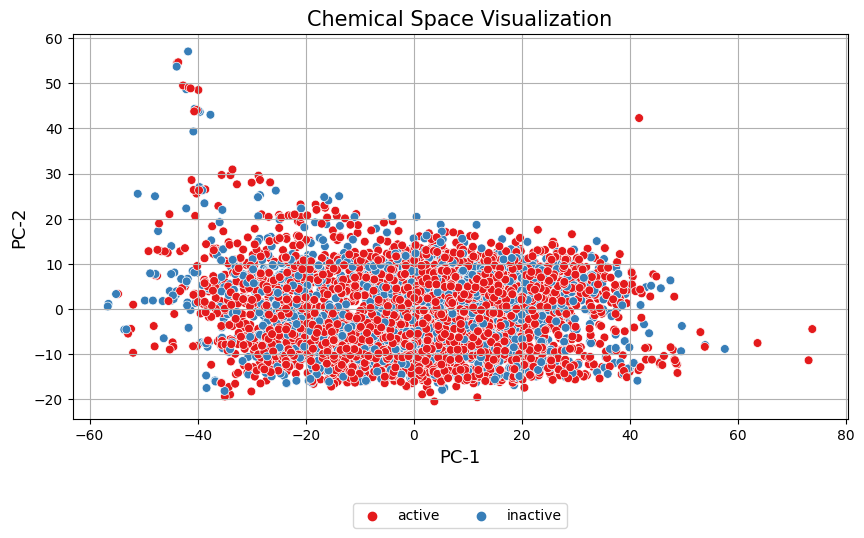

In [30]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_train)
X_pca = pd.DataFrame(X_pca, columns = ["PC-1", "PC-2"])

y_pca = pd.DataFrame(y, columns=["class"]).merge(X_pca, how="inner", left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10, 5))
scatter = sns.scatterplot(x="PC-1", y="PC-2", data=y_pca, s=40, hue="class", palette="Set1", ax=ax)
ax.legend(loc='upper right')
legend_handles, _ = ax.get_legend_handles_labels()
ax.legend(legend_handles, ['active', 'inactive'], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
scatter.set_xlabel("PC-1", fontsize=13)
scatter.set_ylabel("PC-2", fontsize=13)
scatter.grid()
plt.title("Chemical Space Visualization", fontsize=15)
# plt.ylim(-7.5, 12.5)
# plt.xlim(-5, 25)
plt.savefig("csvis.svg", format="svg", bbox_inches='tight')
plt.show()

## Model Training

Train and test AdaBoost model

In [25]:
adaboost = AdaBoostClassifier(random_state=seed)
adaboost.fit(X_train, y_train)

train_pred_adaboost = adaboost.predict(X_train)
test_pred_adaboost = adaboost.predict(X_test)

print("Training Set")
print("================ Classification Report ================")
print(classification_report(y_train, train_pred_adaboost, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_train, train_pred_adaboost))

print("\nTesting Set")
print("================ Classification Report ================")
print(classification_report(y_test, test_pred_adaboost, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_test, test_pred_adaboost))

Training Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.7817    0.8879    0.8314      3674
           1     0.7526    0.5790    0.6545      2164

    accuracy                         0.7734      5838
   macro avg     0.7671    0.7334    0.7429      5838
weighted avg     0.7709    0.7734    0.7658      5838

================ Confusion Matrix ================
[[3262  412]
 [ 911 1253]]

Testing Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.7700    0.8856    0.8238       900
           1     0.7576    0.5750    0.6538       560

    accuracy                         0.7664      1460
   macro avg     0.7638    0.7303    0.7388      1460
weighted avg     0.7653    0.7664    0.7586      1460

================ Confusion Matrix ================
[[797 103]
 [238 322]]


Train and test Extra Trees model

In [26]:
et = ExtraTreesClassifier(random_state=seed)
et.fit(X_train, y_train)

train_pred_et = et.predict(X_train)
test_pred_et = et.predict(X_test)

print("Training Set")
print("================ Classification Report ================")
print(classification_report(y_train, train_pred_et, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_train, train_pred_et))

print("\nTesting Set")
print("================ Classification Report ================")
print(classification_report(y_test, test_pred_et, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_test, test_pred_et))

Training Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.9800    0.9989    0.9894      3674
           1     0.9981    0.9653    0.9814      2164

    accuracy                         0.9865      5838
   macro avg     0.9890    0.9821    0.9854      5838
weighted avg     0.9867    0.9865    0.9864      5838

================ Confusion Matrix ================
[[3670    4]
 [  75 2089]]

Testing Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.8354    0.8911    0.8624       900
           1     0.8040    0.7179    0.7585       560

    accuracy                         0.8247      1460
   macro avg     0.8197    0.8045    0.8104      1460
weighted avg     0.8234    0.8247    0.8225      1460

================ Confusion Matrix ================
[[802  98]
 [158 402]]


Train and test Gradient Boosting model

In [27]:
gbt = GradientBoostingClassifier(random_state=seed)
gbt.fit(X_train, y_train)

train_pred_gbt = gbt.predict(X_train)
test_pred_gbt = gbt.predict(X_test)

print("Training Set")
print("================ Classification Report ================")
print(classification_report(y_train, train_pred_gbt, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_train, train_pred_gbt))

print("\nTesting Set")
print("================ Classification Report ================")
print(classification_report(y_test, test_pred_gbt, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_test, test_pred_gbt))

Training Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.8212    0.9036    0.8604      3674
           1     0.8028    0.6659    0.7280      2164

    accuracy                         0.8155      5838
   macro avg     0.8120    0.7848    0.7942      5838
weighted avg     0.8144    0.8155    0.8113      5838

================ Confusion Matrix ================
[[3320  354]
 [ 723 1441]]

Testing Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.8091    0.8856    0.8456       900
           1     0.7832    0.6643    0.7188       560

    accuracy                         0.8007      1460
   macro avg     0.7961    0.7749    0.7822      1460
weighted avg     0.7992    0.8007    0.7970      1460

================ Confusion Matrix ================
[[797 103]
 [188 372]]


Train and test Random Forest model

In [28]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)

train_pred_rf = rf.predict(X_train)
test_pred_rf = rf.predict(X_test)

print("Training Set")
print("================ Classification Report ================")
print(classification_report(y_train, train_pred_rf, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_train, train_pred_rf))

print("\nTesting Set")
print("================ Classification Report ================")
print(classification_report(y_test, test_pred_rf, digits=4))
print("================ Confusion Matrix ================")
print(confusion_matrix(y_test, test_pred_rf))

Training Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.9852    0.9935    0.9893      3674
           1     0.9887    0.9746    0.9816      2164

    accuracy                         0.9865      5838
   macro avg     0.9870    0.9840    0.9855      5838
weighted avg     0.9865    0.9865    0.9864      5838

================ Confusion Matrix ================
[[3650   24]
 [  55 2109]]

Testing Set
================ Classification Report ================
              precision    recall  f1-score   support

           0     0.8405    0.8844    0.8619       900
           1     0.7973    0.7304    0.7623       560

    accuracy                         0.8253      1460
   macro avg     0.8189    0.8074    0.8121      1460
weighted avg     0.8239    0.8253    0.8237      1460

================ Confusion Matrix ================
[[796 104]
 [151 409]]


Visualize the ROC curve of each model

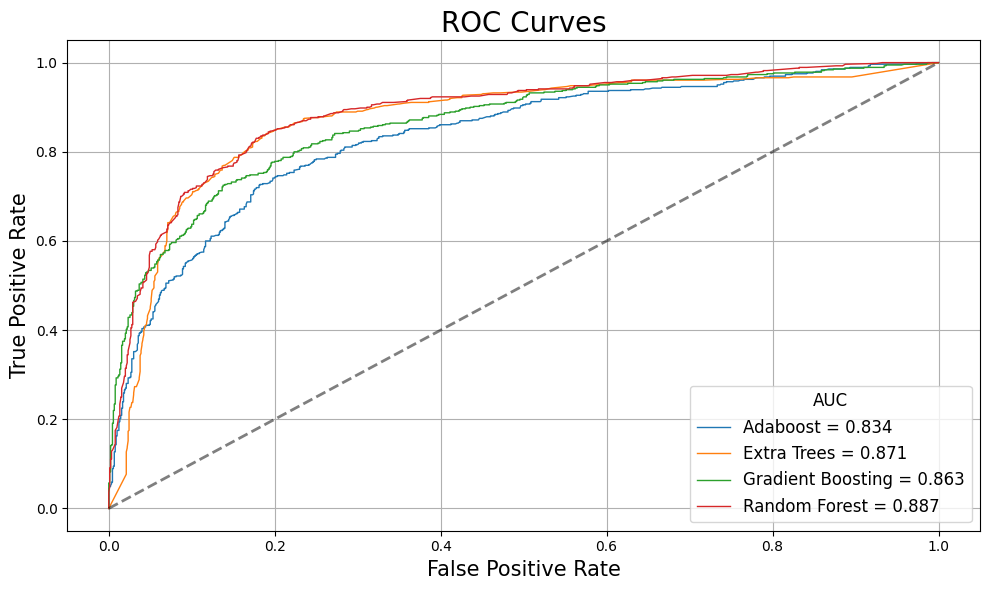

In [29]:
models = [("Adaboost", adaboost),
          ("Extra Trees", et),
          ("Gradient Boosting", gbt),
          ("Random Forest", rf)]

plt.figure(figsize=(10, 6))
for name, model in models:
    clf_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, clf_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} = {roc_auc:.3f}", lw=1)
plt.plot([0, 1], [0, 1], color="black", lw=2, alpha=0.5, linestyle="--")
plt.title("ROC Curves", fontsize=20)
plt.xlabel("False Positive Rate", fontsize=15)
plt.ylabel("True Positive Rate", fontsize=15)
plt.legend(fontsize=12, title="AUC", title_fontsize=12)
plt.grid()
plt.tight_layout()
plt.savefig("testt.svg", format="svg")
plt.show()